In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Plotting Functions

In [2]:
def plot_prior(prior_predictions, data):
    obs = prior_predictions.prior_predictive["obs"].stack(sample=("chain","draw"))
    for col in range(obs.shape[1]):
        plot_data = pd.DataFrame({"Subject":data["Subject"], "Days": data["Days"], "obs": obs[:,col]})
        for subj in range(1):
            x = plot_data[plot_data["Subject"] == subj]["Days"].to_numpy().reshape(-1,1)
            y = plot_data[plot_data["Subject"] == subj]["obs"].to_numpy().reshape(-1,1)
            from sklearn.linear_model import LinearRegression
            lr = LinearRegression()
            lr.fit(x,y)
            pred = lr.predict(x)
            # plt.scatter(x,y, color="k", alpha=0.05)
            plt.plot(x, pred, color="k", alpha=0.2)


def plot_posterior(posterior_predictions, data):
    obs = posterior_predictions.posterior_predictive["obs"].stack(sample=("chain","draw")).median(axis=1)
    plot_data = pd.DataFrame({"Subject":data["Subject"], "Days": data["Days"], "Reaction": data["Reaction"], "obs": obs})

    # fig, ax = plt.subplots(figsize=(8,6))
    plt.set_cmap("tab20c")
    for subj in range(N_subj):
        x = plot_data[plot_data["Subject"] == subj]["Days"]
        y = plot_data[plot_data["Subject"] == subj]["Reaction"]
        obs = plot_data[plot_data["Subject"] == subj]["obs"]

        plt.plot(x, obs, alpha=0.5)
        plt.scatter(x, y, s=5)

In [3]:
data = pd.read_csv("data/sleepstudy.csv")
le = LabelEncoder()
data["Subject"] = le.fit_transform(data["Subject"])
N_subj = len(le.classes_)

In [4]:
data.head()

,Obs,Reaction,Days,Subject
0,1,249.5600,0,0
1,2,258.7047,1,0
2,3,250.8006,2,0
3,4,321.4398,3,0
4,5,356.8519,4,0


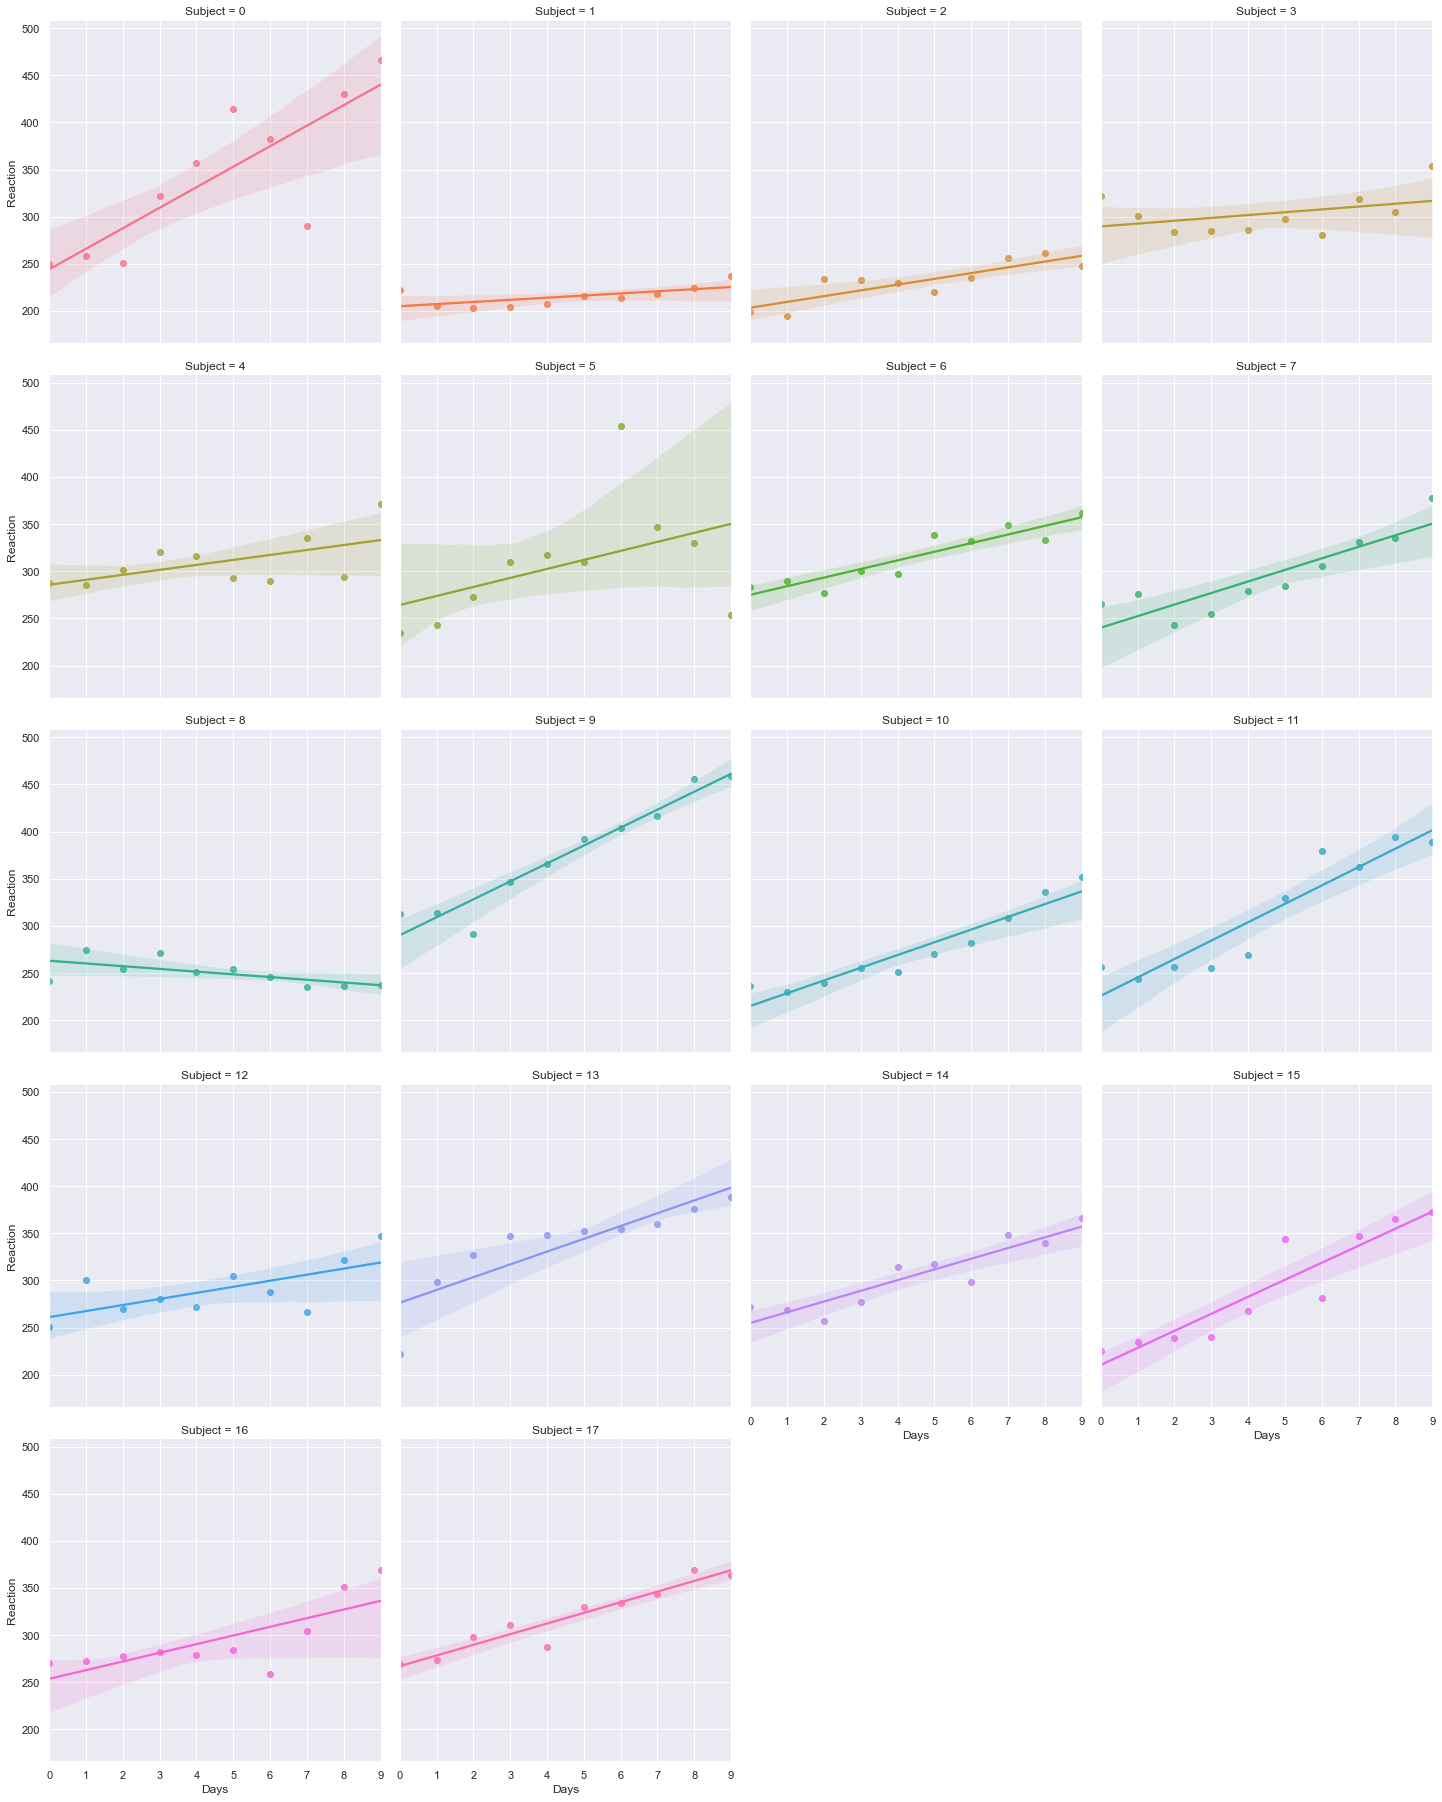

In [5]:
sns.lmplot(data=data, x="Days", y="Reaction", col="Subject",hue="Subject", col_wrap=4)

## Basic Linear Regression

In [6]:
with pm.Model() as m0:
    days = pm.Data("days", data["Days"])
    reaction = pm.Data("reaction", data["Reaction"])

    a_0 = pm.Normal("a_0", mu=250, sigma=50)
    b_0 = pm.Normal("b_0", mu=0, sigma=20)

    y = a_0 + b_0 * days
    
    sigma_y = pm.Exponential("sigma_y", 1/10)
    
    obs = pm.Normal("obs", mu=y, sigma=sigma_y, observed=reaction)

    m0_prior = pm.sample_prior_predictive(50)

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pymc/data.py:667: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


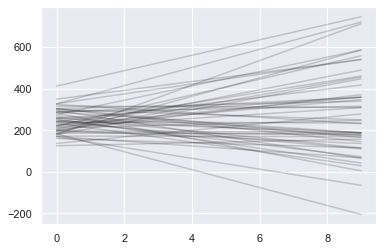

In [7]:
plot_prior(m0_prior, data)

Sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_0, b_0, sigma_y]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 71 seconds.


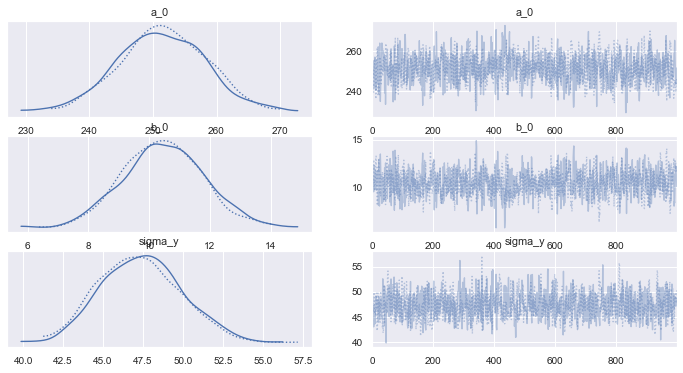

In [8]:
with m0:
    m0_trace = pm.sample()
    m0_posterior = pm.sample_posterior_predictive(m0_trace)
    pm.plot_trace(m0_trace)

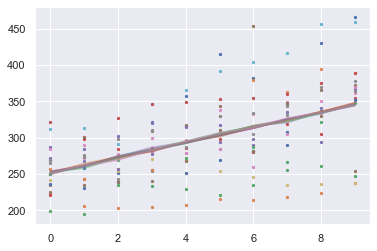

In [9]:
plot_posterior(m0_posterior, data)

## Random intercepts

One version of the parameterization - I don't prefer this but it's equivalent to the next one

In [10]:
if True == False:

    with pm.Model() as m1:
        days = pm.Data("days", data["Days"])
        reaction = pm.Data("reaction", data["Reaction"])
        subject = pm.Data("subject", data["Subject"])

        mu_a0 = pm.Normal("mu_a0", mu=250, sigma=40)
        sigma_a0 = pm.Exponential("sigma_a0", 1/10)
        a1 = pm.Normal("a1",mu=mu_a0, sigma=sigma_a0, shape=N_subj)
        
        b0 = pm.Normal("b0",mu=0, sigma=20)

        y = a1[subject] + b0 * days
        sigma_y = pm.Exponential("sigma_y", 1/10)

        likelihood = pm.Normal("obs", mu=y, sigma=sigma_y, observed=reaction)

    with m1:
        m1_priors = pm.sample_prior_predictive(20)

    with m1:
        m1_trace = pm.sample()
        pm.plot_trace(m1_trace)

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pymc/data.py:667: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a0, sigma_a0, a1, b0, sigma_y]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is 

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 169 seconds.
The acceptance probability does not match the target. It is 0.8868, but should be close to 0.8. Try to increase the number of tuning steps.


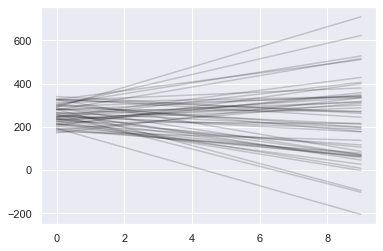

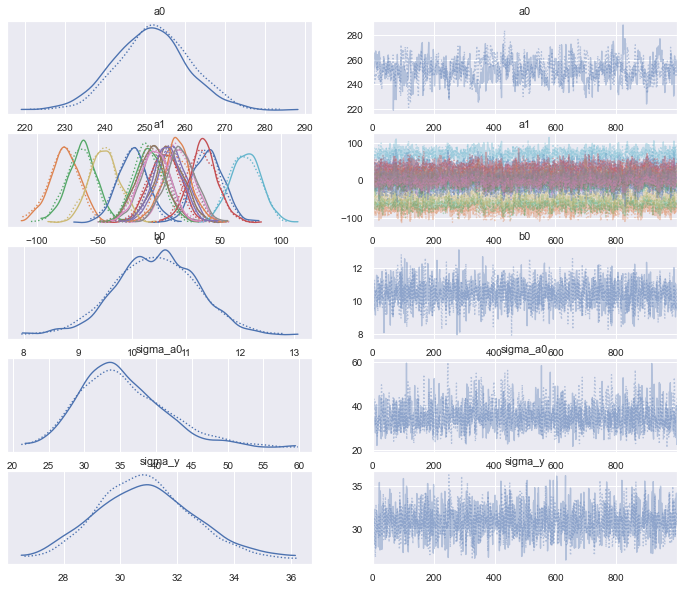

In [11]:
with pm.Model() as m1_b:
    days = pm.Data("days", data["Days"])
    reaction = pm.Data("reaction", data["Reaction"])
    subject = pm.Data("subject", data["Subject"])

    a0 = pm.Normal("a0", mu=250, sigma=40)
    
    sigma_a1 = pm.Exponential("sigma_a0", 1/10)
    a1 = pm.Normal("a1",mu=0, sigma=sigma_a1, shape=N_subj)
    
    b0 = pm.Normal("b0",mu=0, sigma=20)

    y = (a0 + a1[subject]) + b0 * days
    sigma_y = pm.Exponential("sigma_y", 1/10)

    obs = pm.Normal("obs", mu=y, sigma=sigma_y, observed=reaction)
    m1_b_prior = pm.sample_prior_predictive(50)
    plot_prior(m1_b_prior, data)

with m1_b:
    m1_b_trace = pm.sample()
    pm.plot_trace(m1_b_trace)
    m1_b_posterior = pm.sample_posterior_predictive(m1_b_trace)

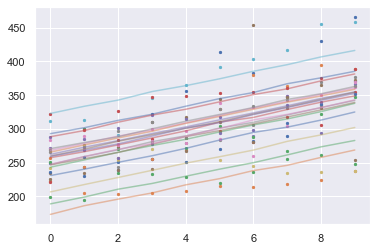

In [12]:
plot_posterior(m1_b_posterior, data)

## Random Intercept and Slope

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pymc/data.py:667: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


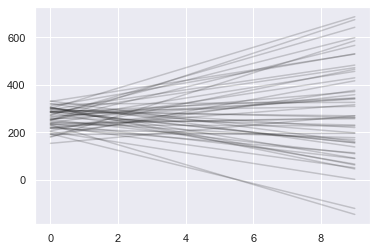

In [13]:
with pm.Model() as m2:
    days = pm.Data("days", data["Days"])
    reaction = pm.Data("reaction", data["Reaction"])
    subject = pm.Data("subject", data["Subject"])
    
    a0 = pm.Normal("a0", mu=250, sigma=40)
    
    sigma_a1 = pm.Exponential("sigma_a1", 1/10)
    a1 = pm.Normal("a1",mu=0, sigma=sigma_a1, shape=N_subj)

    b0 = pm.Normal("b0",mu=0, sigma=20)
    
    sigma_b1 = pm.Exponential("sigma_b1", 1/10)
    b1 = pm.Normal("b1",mu=0, sigma=sigma_b1, shape=N_subj)

    y = (a0 + a1[subject]) + (b0 + b1[subject]) * days
    sigma_y = pm.Exponential("sigma_y", 1/10)

    obs = pm.Normal("obs", mu=y, sigma=sigma_y, observed=reaction)
    m2_prior = pm.sample_prior_predictive(50)
    
plot_prior(m2_prior, data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a0, sigma_a1, a1, b0, sigma_b1, b1, sigma_y]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 201 seconds.


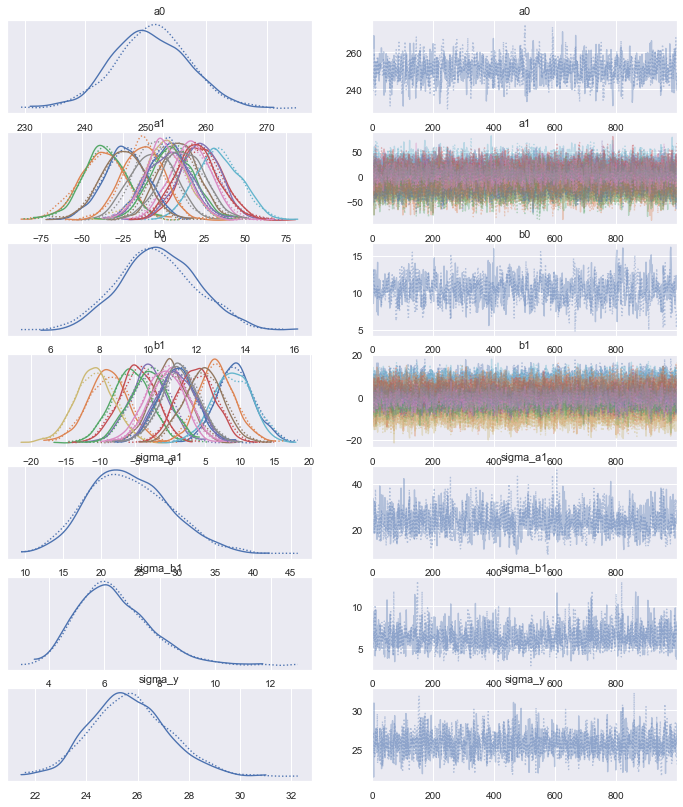

In [14]:
with m2:
    m2_trace = pm.sample()
    pm.plot_trace(m2_trace)
    m2_posterior = pm.sample_posterior_predictive(m2_trace)


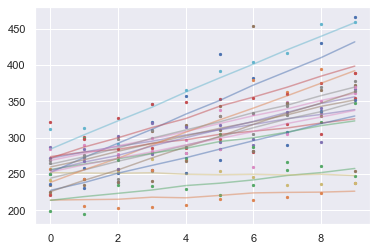

In [15]:
plot_posterior(m2_posterior, data)

## Random Intercept and Slope and w/in Subject Variance

In [16]:
with pm.Model() as m3:
    days = pm.Data("days", data["Days"])
    reaction = pm.Data("reaction", data["Reaction"])
    subject = pm.Data("subject", data["Subject"])
    
    a0 = pm.Normal("a0", mu=250, sigma=40)
    
    sigma_a1 = pm.Exponential("sigma_a1", 1/10)
    a1 = pm.Normal("a1",mu=0, sigma=sigma_a1, shape=N_subj)

    b0 = pm.Normal("b0",mu=0, sigma=20)
    
    sigma_b1 = pm.Exponential("sigma_b1", 1/10)
    b1 = pm.Normal("b1",mu=0, sigma=sigma_b1, shape=N_subj)

    y = (a0 + a1[subject]) + (b0 + b1[subject]) * days
    sigma_y = pm.Exponential("sigma_y", 1/10)
    s_s = pm.Exponential("s_s", 1/10)
    sigma_s = pm.Exponential("sigma_s", s_s, shape=N_subj)

    obs = pm.Normal("obs", mu=y, sigma=sigma_y + sigma_s[subject], observed=reaction)
    

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pymc/data.py:667: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a0, sigma_a1, a1, b0, sigma_b1, b1, sigma_y, s_s, sigma_s]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 251 seconds.


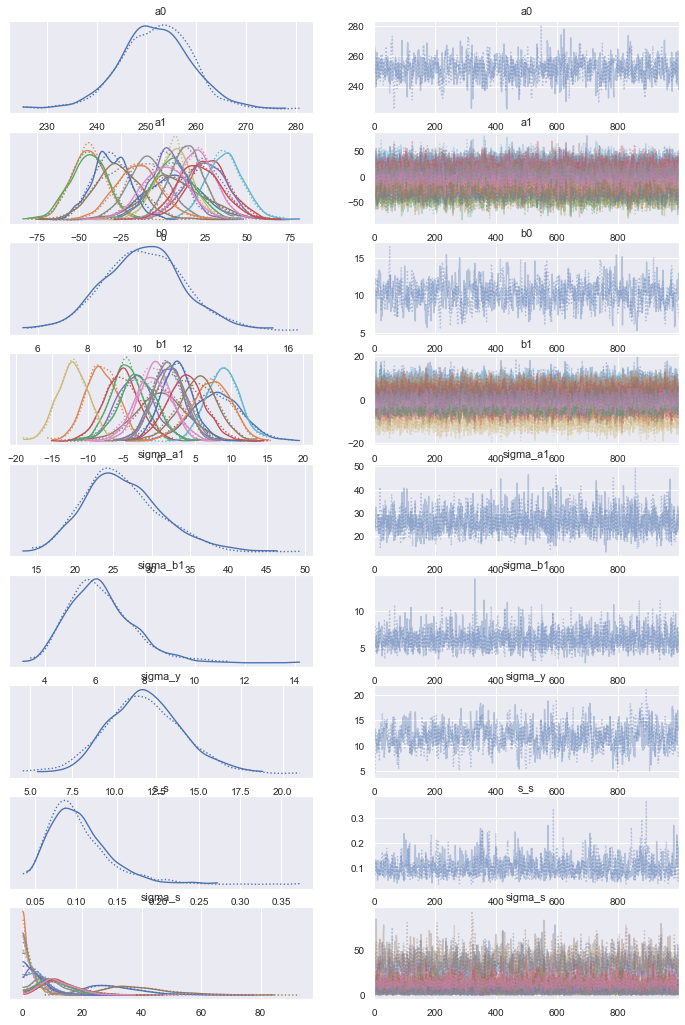

In [18]:
with m3:
    m3_trace = pm.sample()
    pm.plot_trace(m3_trace)
    m3_posterior = pm.sample_posterior_predictive(m3_trace)

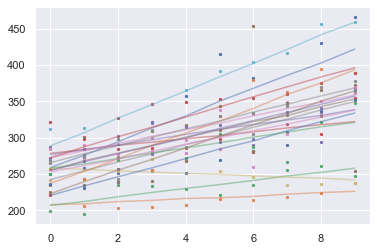

In [22]:
plot_posterior(m3_posterior, data)

### Model Comparison
by RMSE


In [23]:
def rmse(y, posterior):
    y_pred = posterior.posterior_predictive["obs"].stack(sample=("chain","draw")).median(axis=1)
    return np.sqrt(mean_squared_error(y, y_pred))
    

In [24]:
print("Model : Error (RMSE)")
posteriors = [m0_posterior, m1_b_posterior, m2_posterior, m3_posterior]
models = ["m0", "m1", "m2", "m3"]

for model, post in zip(models,posteriors):
    error = rmse(data["Reaction"], post)
    print(f"{model}    - {error}")

Model : Error (RMSE)
m0    - 47.53287352874142
m1    - 29.49965357130687
m2    - 23.433828904017666
m3    - 23.24048418643037
